## _Data Challenge | DeepWater_

#### Packages

In [1]:
import nltk
import re
import sys
import numpy as np
from os import path
from scipy import sparse
import pandas as pd
import seaborn as sns
import xgboost as xgb
from collections import Counter
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
nltk.download('wordnet') 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import TfidfTransformer
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix, f1_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adodo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adodo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#### Chargement des données et Aperçu

In [2]:
df = pd.read_csv('dataset.csv', sep = ';', on_bad_lines = 'skip')
df.head()

,Text,label
0,FORMATION PRESSURE WORKSHEET Well No. : 6305/1...,1
1,SANTOS LIMITED RCI PRESSURE SURVEY WELL: BALCA...,1
2,-GGryoro RFT RESULTS WELL: 6407/7-—2 RUN NO. 2...,1
3,SANTOS LIMITED FMT PRESSURE SURVEY (Field Data...,1
4,1 Test No. 10 2 MD mRKB 2006.0 2006.2 3 TVD m...,1


#### Informations sur les données

In [3]:
df.info()
print('----------------------------------')
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    125 non-null    object
 1   label   125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB
----------------------------------
(125, 2)


In [4]:
# Copie du dataset
dataset = df

#### WordCount

In [5]:
dataset['word_count'] = dataset['Text'].apply(lambda x: len(str(x).split(" ")))
dataset[['Text','word_count']].head()

,Text,word_count
0,FORMATION PRESSURE WORKSHEET Well No. : 6305/1...,82
1,SANTOS LIMITED RCI PRESSURE SURVEY WELL: BALCA...,532
2,-GGryoro RFT RESULTS WELL: 6407/7-—2 RUN NO. 2...,219
3,SANTOS LIMITED FMT PRESSURE SURVEY (Field Data...,489
4,1 Test No. 10 2 MD mRKB 2006.0 2006.2 3 TVD m...,305


#### WordCount Stat

In [6]:
# Stat sur le wordcount
# dataset.word_count.describe()

# les mots les plus courants
# freq = pd.Series(' '.join(corpus).split()).value_counts()[:50]
# freq

# les mots les moins ourants
# freq1 =  pd.Series(' '.join(dataset['Text']).split()).value_counts()[-10:]
# freq1

### Prétraitement du texte | Text cleanning

In [7]:
stop_words = set(stopwords.words("english"))
# new_words = ["n"]
# stop_words = stop_words.union(new_words)

In [8]:
dataset.iloc[:,0]

0      FORMATION PRESSURE WORKSHEET Well No. : 6305/1...
1      SANTOS LIMITED RCI PRESSURE SURVEY WELL: BALCA...
2      -GGryoro RFT RESULTS WELL: 6407/7-—2 RUN NO. 2...
3      SANTOS LIMITED FMT PRESSURE SURVEY (Field Data...
4       1 Test No. 10 2 MD mRKB 2006.0 2006.2 3 TVD m...
                             ...                        
120    « {8 = 2.1./ Biostratigraphic Summary (Accordi...
121    Core No. 4: 1555 - 1564 m recovered 82 % Core ...
122    XIX. XX. XXI. eu XXII. sey” XXIII. AXIV. 3683....
123    Page 02 of 07 VI. 3658.83 - 3658.94 m Intbd'd ...
124    e -30 - 7 LOGGING 7.1 Wireline logs The follow...
Name: Text, Length: 125, dtype: object

In [9]:
corpus = []
for i in range(0, 125):
    # Suppression des ponctuations
    text = re.sub('[^a-zA-Z]', ' ', dataset['Text'][i])
    
    # convertir en minuscule
    text = text.lower()
    
    # Suppression des balises
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # suppression des caracères spéciaux
    text=re.sub("(\\d|\\W)+"," ",text)
    
    # Conversion en liste
    text = text.split()
    
    # normalisation de type lammélisation (on extrait de chaque mot les expressions non régulières)
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

In [10]:
corpus[11]

'santos limited fmt survey well barina rt gaugetype strain page witness le burgess time since last circ hour probe packer type standard date maximum temperature f expect expect test result interpretation formation form temp sand press hydro hydro draw type depltn comment static static build super fluid type mobility charging ft ft psia psia psia psia f md cp drawdowns ce patch limited tight aborted psi min patch limited tight aborted psi min patch limited tight aborted psi min patch normal slow curtailed patch normal good depleted stabilised patch normal good depleted stabilised patch ormal slow aborted psi min patch ormal good aborted suspected plugging patch normal slow depleted curtailed psi min patch ormal rapid stabilised patch ormal rapid stabilised patch ormal slow curtailed psi min patch ormal good stabilised patch normal slow curtailed psi min patch normal slow curtailed psi min patch ormal slow curtailed psi min basement ormal slow curtailed psi min basement normal slow deple

#### WordCloud

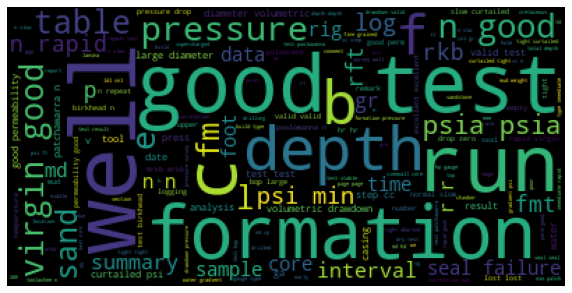

In [11]:
wordcloud = WordCloud(stopwords=stop_words).generate(str(corpus))
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Text Preparation

- La tokenisation est le processus de conversion du texte continu en une liste de mots.



- La vectorisation, appelée extraction de caractéristiques convertie la liste de mots en une matrice d'entiers par le processus de vectorisation.


#### Important


Je ne considère pas les séquences de mots, mais plutot la fréquence des mots.

##### Paramètres de la fonction

- max_df : Lors de la construction du vocabulaire, ignorez les termes qui ont une fréquence strictement supérieure au seuil donné dans le corpus. Cela permet de s'assurer que nous n'avons que des mots pertinents pour le contexte et non des mots couramment utilisés.




- max_features: détermine le nombre de colonnes dans la matrice.



- n-gram_range : nous voudrions regarder une liste de mots simples, deux mots (bi-grammes) et trois mots (tri-grammes) combinaisons.

In [12]:
cv = CountVectorizer(max_df = 0.8, stop_words = stop_words, max_features = 50, ngram_range = (1,3))
X = cv.fit_transform(corpus)

In [13]:
print(list(cv.vocabulary_.keys()))

['formation', 'pressure', 'well', 'rkb', 'sample', 'type', 'depth', 'test', 'result', 'psia', 'md', 'cc', 'ft', 'min', 'psi', 'tight', 'good', 'rft', 'run', 'permeability', 'mrkb', 'hr', 'sand', 'curtailed', 'gr', 'gradient', 'drawdown', 'normal', 'water', 'mud', 'rapid', 'slow', 'good test', 'table', 'perm', 'seal', 'hole', 'valid', 'fm', 'ee', 'page', 'patchawarra', 'repeat', 'lost', 'log', 'virgin', 'virgin good', 'interval', 'core', 'group']


### Visualisation des tops occurence de mots (uni, bi et tri)

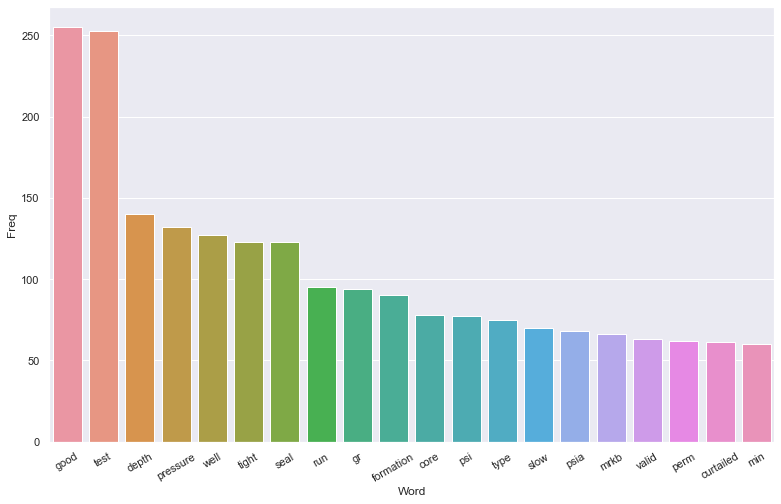

In [14]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]
# print(top_df)
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30);

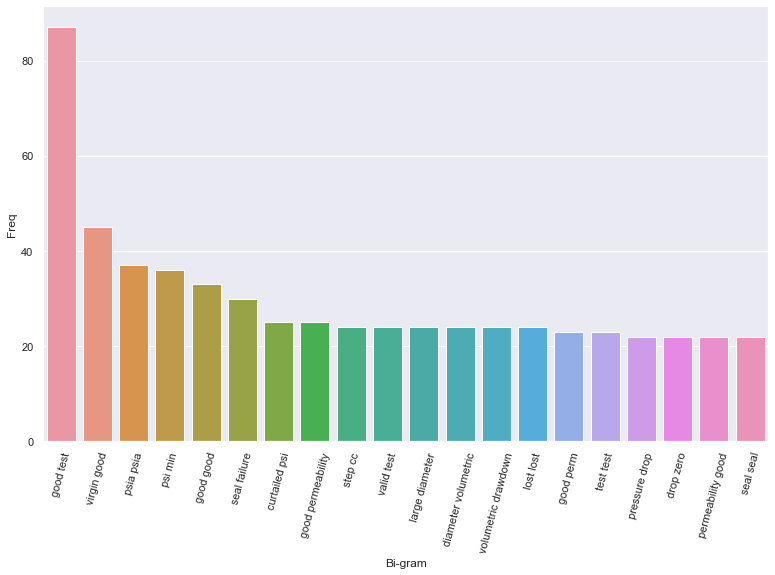

In [15]:
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(ngram_range=(2,2),  
            max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]
top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
# print(top2_df)
#Barplot of most freq Bi-grams
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=75);

In [16]:
X

<125x50 sparse matrix of type '<class 'numpy.int64'>'
	with 1105 stored elements in Compressed Sparse Row format>

In [17]:
# Conversion de la matrice en entier
# tfidf_transformer = TfidfTransformer(smooth_idf = True,use_idf = True)
# tfidf_transformer.fit(X)
# get feature names
# feature_names = cv.get_feature_names_out()
# feature_names

In [18]:
corpus

['formation pressure worksheet well rig transocean date pressure unit bar rkb msl witnessed waldum initial formation hydrostatic press pressure remark temp deg c deg c sample recovered lst chamber opened shut pressure bar nd chamber opened shut pressure bar',
 'santos limited rci pressure survey well balcaminga r tool gauge type qtzdyne witness p mcgilveray time since last circ probe packer standard standard date formation depth depth file test result psia interpretation comment rt subsea hydro final form hydro temp type test rate type depl fluid type md buildup press mob time change build c cc dd ft ft psia psia psia psia degf md cp min psi min correlation epsilon n slw step cc tc n slw tight cc tight n slw tight step cc n slw tight step cc n slw tight step cc tc n good step cc n good step cc psi n good step cc psi tc n immed step cc n immed step cc n immed step cc n immed step cc correlation patch n good sc step cc vc n good sc draw n good sc step cc n v slw step cc vc n slw sc step 

In [19]:
X1 = sparse.csr_matrix.toarray(X)

In [20]:
X1

array([[ 0,  0,  0, ...,  0,  0,  1],
       [26,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  1]], dtype=int64)

In [21]:
input_val = pd.DataFrame(X1)

In [22]:
Y = dataset.iloc[:,1].values

In [23]:
Y

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', 'label', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0'], dtype=object)

In [24]:
Y = np.where(Y == 'label', '1', Y)

In [25]:
Y

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0'], dtype=object)

In [26]:
X_train1,X_test1,Y_train1,Y_test1 = train_test_split(input_val,Y,test_size = 0.20, stratify = Y)
print(X_train1.shape,X_test1.shape,Y_train1.shape,Y_test1.shape)

(100, 50) (25, 50) (100,) (25,)


Counter({'0': 61, '1': 39})


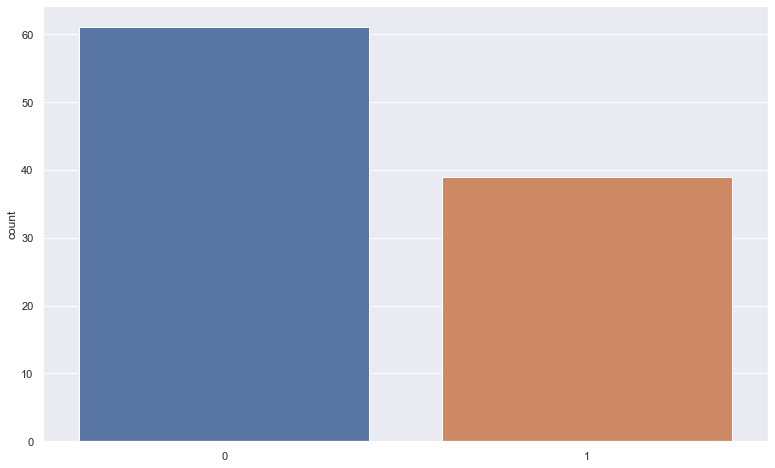

In [27]:
counter1 = Counter(Y_train1)
print(counter1)
distribution1 = sns.countplot(x = Y_train1)
plt.show()
counteri = Counter(Y_test1)

## Regression logistique

In [28]:
classifier1 = LogisticRegression(random_state = 0).fit(X_train1, Y_train1)
y_pred1 = classifier1.predict(X_test1)
print(Y_test1.shape, y_pred1.shape)

(25,) (25,)


Test score 1: 92.00%
[[15  0]
 [ 2  8]]
25
Counter({'0': 15, '1': 10})


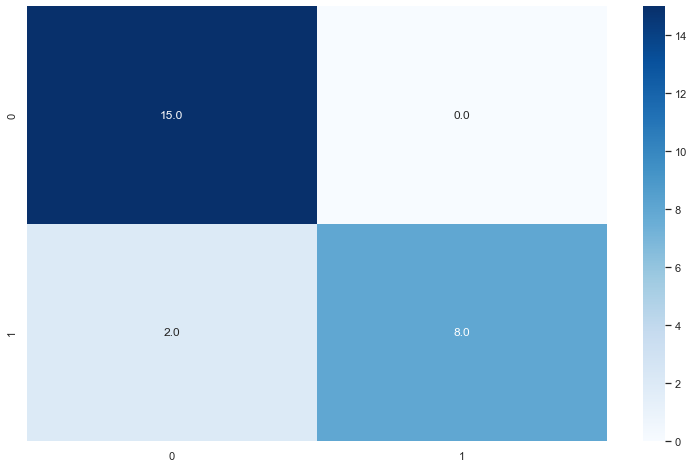

In [29]:
test_score1 = classifier1.score(X_test1, Y_test1)
print("Test score 1: %.2f%%" % (test_score1 * 100.0))
matthews_score1 = matthews_corrcoef(Y_test1, y_pred1)
matrice_confusion1 = confusion_matrix(Y_test1, y_pred1)
print(matrice_confusion1)
print(np.sum(matrice_confusion1))
sns.heatmap(matrice_confusion1, annot = True, cmap = 'Blues', fmt = '.1f')
print(counteri)

## Random Forest

In [30]:
classifier1R = RandomForestClassifier(random_state = 50).fit(X_train1, Y_train1)
y_pred1R = classifier1R.predict(X_test1)
print(Y_test1.shape, y_pred1R.shape)

(25,) (25,)


Test score 1 R: 84.000%
[[13  2]
 [ 2  8]]
Counter({'0': 15, '1': 10})


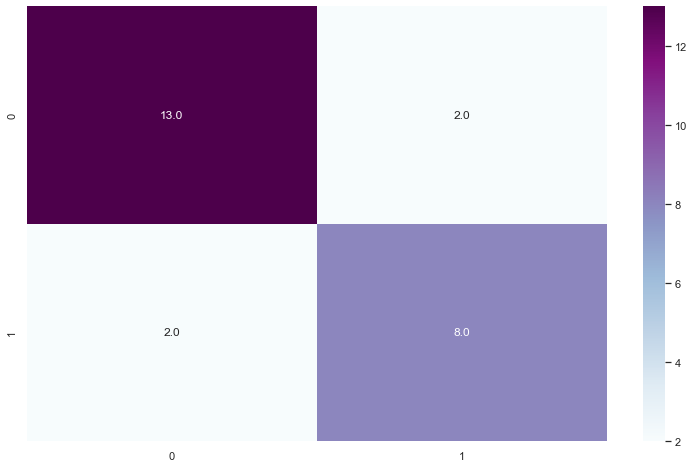

In [31]:
test_score1R = classifier1R.score(X_test1, Y_test1)
print("Test score 1 R: %.3f%%" % (test_score1R * 100.0))
matrice_confusion1R = confusion_matrix(Y_test1, y_pred1R)
print(matrice_confusion1R)
sns.heatmap(matrice_confusion1R, annot = True, cmap = 'BuPu', fmt = '.1f')
print(counteri)